In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from datetime import timedelta, datetime
from termcolor import colored

aims:
1. extract features from test failing vehicles
2. build classification model for predicting outcome of emission test for vehicles

additionals:

1. new customer - prediction
2. return customer - prediction
3. predict test cost

# import data
[here](https://opendata.cabq.gov/dataset/vehicle-emissions/resource/2663c138-549e-4d55-932f-6aa549c7d158) is the MetaData


In [3]:
df_all = pd.read_csv('../data/sample201320.csv', low_memory=False)

print("data size:", df_all.shape)
df_all.head(2)

data size: (193310, 127)


,RecordID,RECORD_NUM,VIR_CERT_NUMBER,STATION_NUM,ANALYZER_NUM,INSPECTOR_NUM,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VIN,VIN_SOURCE,VEH_LICENSE,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,ESC,VRT_RECORD_ID,E_TEST_SEQUENCE,E_PRECOND_PROCEDURE,E_HIGH_DCF,E_HIGH_RPM,E_HIGH_CO2,E_HIGH_O2,E_HIGH_HC,E_HIGH_HC_DCF,E_HIGH_HC_LIMIT,E_HIGH_CO,E_HIGH_CO_DCF,E_HIGH_CO_LIMIT,E_IDLE_DCF,E_IDLE_RPM,E_IDLE_CO2,E_IDLE_O2,E_IDLE_HC,E_IDLE_HC_DCF,E_IDLE_HC_LIMIT,E_IDLE_CO,E_IDLE_CO_DCF,E_IDLE_CO_LIMIT,E_HIGH_DCF_2,E_HIGH_RPM_2,E_HIGH_CO2_2,E_HIGH_O2_2,E_HIGH_HC_2,E_HIGH_HC_DCF_2,E_HIGH_CO_2,E_HIGH_CO_DCF_2,E_IDLE_DCF_2,E_IDLE_RPM_2,E_IDLE_CO2_2,E_IDLE_O2_2,E_IDLE_HC_2,E_IDLE_HC_DCF_2,E_IDLE_CO_2,E_IDLE_CO_DCF_2,E_RESULT_STRING,V_SMOKE1,V_SMOKE2,V_GASCAP,V_CAT,V_RESULT,KOEO_RESULT,KOER_RESULT,OBD_RDY_MISFIRE,OBD_RDY_FUEL,OBD_RDY_COMPONENT,OBD_RDY_CAT,OBD_RDY_CAT_HEATED,OBD_RDY_EVAP,OBD_RDY_SEC_AIR,OBD_RDY_AIR_COND,OBD_RDY_O2_SENSOR,OBD_RDY_O2_HEATER,OBD_RDY_EGR,OBD_RDY_RESULT,OBD_PID,OBD_PCM_ID,OBD_VIN,OBD_FLT_CODES,OBD_FLT_RESULT,OBD_MIL_STATUS,OBD_RESULT,ONLINE_STATUS,OFFLINE_REASON_CODE,ABORT_CODE,SOFTWARE_VERSION,INSP_COMMENTS,OVERALL_RESULT,R_TOTAL_COST,R_EGR,R_ELECTRICAL,R_EVAP_CONTROL,R_EXHAUST,R_IGNITION,R_INTAKE,R_ENGINE,R_PCV,R_OTHER,SentToWW,ABORT_CODE_OTHER_DESC,OBDII_AFFECT_OVERALL,E_HIGH_CO_RESULT,E_HIGH_HC_RESULT,E_IDLE_CO_RESULT,E_IDLE_HC_RESULT,MECHANIC_LAST_NAME,MECHANIC_FIRST_NAME,MECHANIC_MIDDLE_INIT,ENGINE_SIZE_ORIG,FAILED_IDLE_RPM,SENTTOVID,Station_License_Number,Analyzer_Number,Insert_DateTime
0,2690332,10433,6878785.0,IS311,W028,AC084149,A,A,2013-03-04 10:11:00,2013-03-04 10:14:00,1G4HP52K45U160372,S,368RBP,1.0,3875,2005,BUICK,LESABRE,6,3800,A,N,114034,G,1,5.0,87121,C,6.0,20050189,1,1,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,N,N,P,P,P,P,P,P,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,P,19.0,10,1G4HP52K45U160372,NaN,P,1.0,P,0,0,NaN,502,NaN,P,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,0,NaN,N,N,N,N,N,Huber,Bryan,S,NaN,NaN,0,IS311,W028,2013-03-04 16:26:26
1,2804644,18225,6979071.0,IR317,W039,37826481,I,I,2013-07-22 16:55:00,2013-07-22 16:56:00,3VWSF71K66M706988,S,843NWS,1.0,3250,2006,VOLKSWAGEN,JETTA,5,2500,M,N,76338,G,1,16.0,87108,C,6.0,0,1,1,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,N,N,P,N,P,P,P,P,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,P,38.0,E8,3VWSF71K66M706988,NaN,P,1.0,P,1,0,NaN,502,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,N,N,N,N,N,NGUYEN,HANH,A,2.5L,NaN,0,IR317,W039,2013-07-22 17:41:06


# target

1. keep all the records with OVERALL_RESULT = P or F
2. change to numeric
- P    173762
- F     13741

Num of rows with missing values: 0


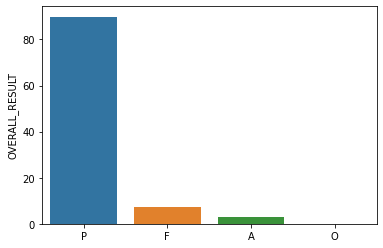

In [4]:
import seaborn as sns
y = df_all['OVERALL_RESULT']
print('Num of rows with missing values:', y.isnull().sum())
tmp = y.value_counts()*100.0/y.shape[0]
sns.barplot(x=tmp.index, y=tmp);

In [5]:
y.value_counts()

P    173762
F     13741
A      5805
O         2
Name: OVERALL_RESULT, dtype: int64

In [6]:
df_all.loc[(df_all.OVERALL_RESULT=='A') & (df_all.ABORT_CODE_OTHER_DESC.notnull()), 'ABORT_CODE_OTHER_DESC'].head(30)

129                               vin wrong
524                    Test Time Expiration
564                       wrong action used
610                             wrong plate
766                    Test Time Expiration
826                    Test Time Expiration
994                              wrong info
1059              WILL NOT PICK UP OBD INFO
1119                   DIDNT NEED EMISSIONS
1147                             wrong info
1472                             wrong year
1802                            wrong plage
1862                   Test Time Expiration
1930                              WRONG CAR
1942              wrong engine size entered
2225                   Test Time Expiration
2283                            wrong plate
2377                               car info
2571                         11000 LBS GVWR
2985                             WRONG INFO
3040                           not required
3137                            WRONG MODEL
3143                            

In [7]:
# drop the rows where the test was aborted
df_all = df_all[~df_all.OVERALL_RESULT.isin(['A','O'])]
df_all.OVERALL_RESULT.value_counts()

P    173762
F     13741
Name: OVERALL_RESULT, dtype: int64

In [8]:
# P=1, F=1
df_all['RESULT'] = df_all['OVERALL_RESULT'].map({'P':1, 'F':0})
df_all.RESULT.value_counts()

1    173762
0     13741
Name: RESULT, dtype: int64

# vehicle features


In [9]:
# find the unique id column
print(df_all.shape[0])
print(df_all[['RecordID', 'RECORD_NUM', 'VIR_CERT_NUMBER']].nunique())

187503
RecordID           187503
RECORD_NUM          31005
VIR_CERT_NUMBER    187312
dtype: int64


In [10]:
# set RecordID as index
df_all.set_index('RecordID', inplace=True)
print("RecordID has been set as index")

RecordID has been set as index


## quick exploration for selecting features

### vehicle features and missing values
- VID_TEST_TYPE:    80462
- GVW_TYPE:            71
- VEH_LICENSE:         13
- MODEL:                2


In [11]:
cols = ['RESULT',
        'TEST_TYPE', 'VID_TEST_TYPE', # which
        'TEST_SDATE', 'TEST_EDATE', 
        'VIN', 
        'ZIP_CODE',
        'VEHICLE_TYPE',
        'MODEL_YEAR', 'MAKE', 'MODEL',
        'GVW_TYPE', 'GVWR', # which
        'CYL', 
        'ENGINE_SIZE', 
        'TRANS_TYPE',
        'DUAL_EXHAUST', 
        'ODOMETER', 
        'FUEL_TYPE']
df = df_all[cols]
df.head()

,RESULT,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VIN,ZIP_CODE,VEHICLE_TYPE,MODEL_YEAR,MAKE,MODEL,GVW_TYPE,GVWR,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE
RecordID,,,,,,,,,,,,,,,,,,,
2690332,1,A,A,2013-03-04 10:11:00,2013-03-04 10:14:00,1G4HP52K45U160372,87121,1,2005,BUICK,LESABRE,1.0,3875,6,3800,A,N,114034,G
2804644,1,I,I,2013-07-22 16:55:00,2013-07-22 16:56:00,3VWSF71K66M706988,87108,1,2006,VOLKSWAGEN,JETTA,1.0,3250,5,2500,M,N,76338,G
2779074,1,I,I,2013-06-18 12:45:00,2013-06-18 12:47:00,1FTRX17W43NA86035,87112,3,2003,FORD,F150 2WD,2.0,6050,8,4600,A,N,104849,G
2761810,1,I,I,2013-05-29 16:17:00,2013-05-29 16:18:00,JTEEP21A560170542,87119,4,2006,TOYOTA,HIGHLANDER 4WD,1.0,5360,6,3300,A,N,70130,G
2733004,0,I,I,2013-04-22 15:54:00,2013-04-22 15:58:00,1G1ZT52865F313274,87111,1,2005,CHEVROLET,MALIBU,1.0,3375,6,3500,A,N,133251,G


In [12]:
df.isnull().sum().sort_values(ascending=False)[:5]

VID_TEST_TYPE    80462
GVW_TYPE            71
MODEL                2
RESULT               0
ODOMETER             0
dtype: int64

In [13]:
# how many unique vehicles
df.VIN.nunique()

86341

### TEST_TYPE VS VID_TEST_TYPE
- drop VID_TEST_TYPE due to the missing values

<AxesSubplot:xlabel='RESULT', ylabel='count'>

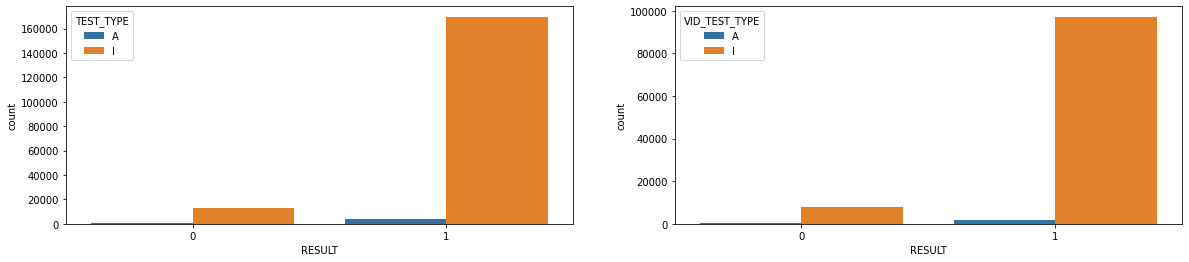

In [14]:
tmp = df[['RESULT','TEST_TYPE', 'VID_TEST_TYPE']]
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
sns.countplot(data=tmp, x='RESULT', hue='TEST_TYPE', ax=axs[0])
sns.countplot(data=tmp, x='RESULT', hue='VID_TEST_TYPE', ax=axs[1])

In [15]:
df = df.drop(columns=['VID_TEST_TYPE'])

### GVW_TYPE vs GVWR
- drop GVW_TYPE


<AxesSubplot:xlabel='RESULT', ylabel='count'>

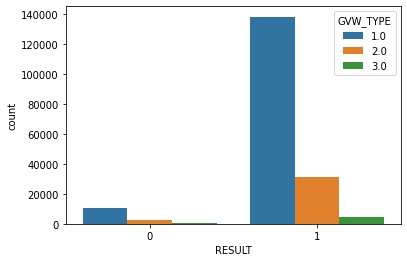

In [16]:
tmp = df[['RESULT','GVW_TYPE', 'GVWR']]
sns.countplot(data=tmp, x='RESULT', hue='GVW_TYPE')

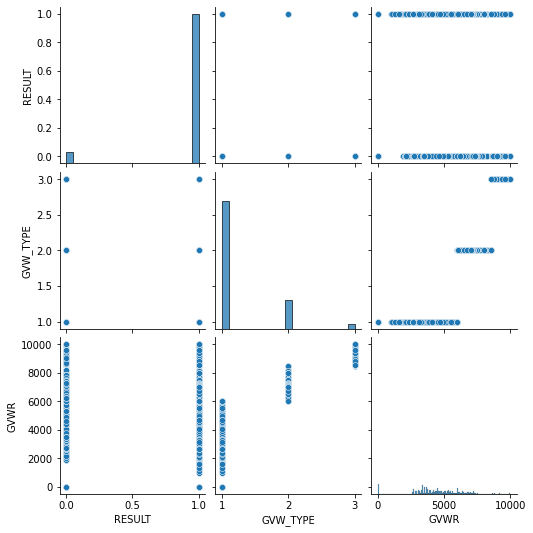

In [17]:
sns.pairplot(tmp)

In [18]:
# drop GVW
df = df.drop(columns=['GVW_TYPE'])

### categorical cols distribution
- drop DUAL_EXHAUST

In [19]:
df.nunique().sort_values()

RESULT               2
TEST_TYPE            2
DUAL_EXHAUST         2
TRANS_TYPE           2
VEHICLE_TYPE         7
FUEL_TYPE            7
CYL                 10
MODEL_YEAR          43
ENGINE_SIZE         83
MAKE                92
ZIP_CODE           468
GVWR              2426
MODEL             2537
VIN              86341
ODOMETER        124790
TEST_EDATE      180666
TEST_SDATE      180717
dtype: int64

In [20]:
df.nunique().sort_values().index

Index(['RESULT', 'TEST_TYPE', 'DUAL_EXHAUST', 'TRANS_TYPE', 'VEHICLE_TYPE',
       'FUEL_TYPE', 'CYL', 'MODEL_YEAR', 'ENGINE_SIZE', 'MAKE', 'ZIP_CODE',
       'GVWR', 'MODEL', 'VIN', 'ODOMETER', 'TEST_EDATE', 'TEST_SDATE'],
      dtype='object')

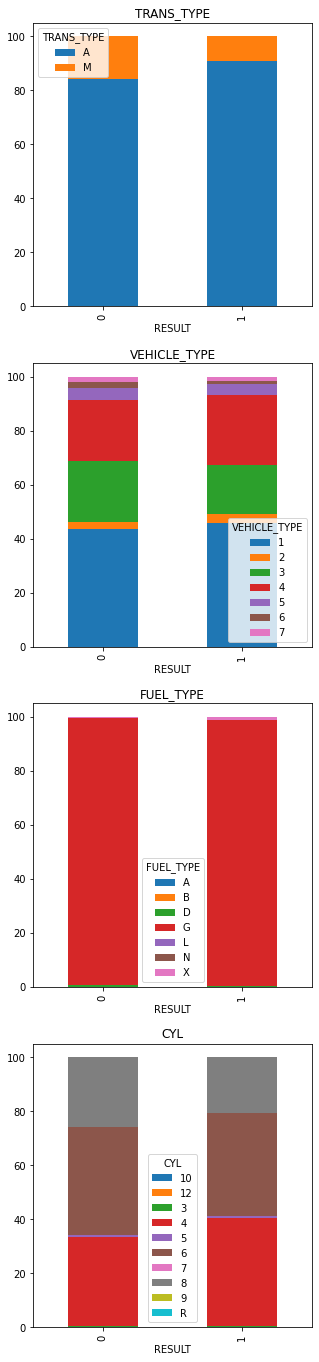

In [21]:
categorical_cols = ['TEST_TYPE', 
                    'TRANS_TYPE', 
                    'VEHICLE_TYPE', 
                    'FUEL_TYPE', 
                    'CYL']

# distribution of categorical values in Pass and Fail data sets
df['count'] = 1
n = len(categorical_cols[1:])
fig, axs = plt.subplots(n, 1, figsize=(5, 6*n))
for col, ax in zip(categorical_cols[1:], axs.flat):
    tmp = df.groupby(['RESULT', col])['count'].count().groupby('RESULT').apply(lambda x: 100*x/x.sum()).unstack(level=1)
    tmp.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(col)
df = df.drop(columns=['count'])

In [22]:
# let's look closer to DUAL_EXHAUST
df.groupby(['RESULT'])['DUAL_EXHAUST'].value_counts()/df.shape[0]

RESULT  DUAL_EXHAUST
0       N               0.072639
        Y               0.000645
1       N               0.921729
        Y               0.004987
Name: DUAL_EXHAUST, dtype: float64

In [23]:
# let's drop dual_exhaust
df = df.drop(columns=['DUAL_EXHAUST'])

## cleaning and feature engineering


**set RecordID as index**

    - total records: 187503
    - P: 173762
    - F: 13741

**string columns : VIN, MAKE, MODEL, ZIP_CODE, MODEL_YEAR**


    - missing values in MODEL: 2
        - using the historical records of that VIN fill in the missing MODEL values


    - engineer new feature: MAKE + MODEL + MODEL_YEAR
        - unique MAKE_MODEL_YEAR: 11684
        - total records: 187503
        
        
    - drop: MODEL, MAKE, MODEL_YEAR
    
    
    - extract features from ZIP_CODE: pause!!!
        - typos
        - zip codes of ABQ are not structured
    
    
    - drop: ZIP_CODE
    
    
final columns: VIN, MAKE_MODEL_YEAR
    

**datetime columns: TEST_SDATE, TEST_EDATE**

    - if a vehicle has multiple records from the same date, keep first record
    
        - records where vehicles got tested more than 1 time a day: 4046
        
        
        - after removing repeated tests from same day
        
        
            - total number of records: 187503 > 183457 
            - P: 173762 > 170120
            - F: 13741 > 13337
            - data range: 2013-01-01/2020-12-31 
            
            
    - engineer feature: VEHICLE_AGE   
        
    - drop TEST_SDATE
    
final columns: VEHICLE_AGE
        
**categorical columns: TEST_TYPE, TRANS_TYPE, VEHICLE_TYPE, FUEL_TYPE, CYL**

    - map to numeric: TEST_TYPE:{'I':0, 'A':1}, TRANS_TYPE:{'A':0, 'M':1}

    - drop VEHICLE_TYPE
        - near 1000 MAKE_MODEL_YEARs had more than 1 VEHICLE_TYPE 
        - it's not clear how vehicle types were defined     
        
    - drop CYL
        - share of fail is higher when CYL is 9, 12 and R
        - however only 82 records whose CYL is 9, 12 and R

    - drop FUEL_TYPE (FUEL_TYPE L only has 4 records and all are Pass)
        - more than 95% of the tests have FUEL_TYPE G

final columns: TEST_TYPE, TRANS_TYPE


**numeric columns: GVWR, ENGINE_SIZE, ODOMETER**
    
    - 0 in GVWR: 11577 (P: 11090, F: 487)
        
        - took the median GVWR values for each VIN
            
        - drop records where GVWR values are missing: 7942 (P: 7560, F: 382) 
        
        - range of GVWR: 847 - 10000
        
    - drop records where ODOMETER = 0 : 875 (P: 746, F: 129) 
    
    - possible outliers in ODOMETER
        - records where ODOMETER > 1 million miles: 229
        - vehicles with ODOMETER > 1 million miles: 218
        
**final columns: RESULT, TEST_TYPE, ENGINE_SIZE, TRANS_TYPE, ODOMETER, VEHICLE_AGE, GVWR**


**final data size: 174651, 8**

### missing values 


In [24]:
df.head(2)

,RESULT,TEST_TYPE,TEST_SDATE,TEST_EDATE,VIN,ZIP_CODE,VEHICLE_TYPE,MODEL_YEAR,MAKE,MODEL,GVWR,CYL,ENGINE_SIZE,TRANS_TYPE,ODOMETER,FUEL_TYPE
RecordID,,,,,,,,,,,,,,,,
2690332,1,A,2013-03-04 10:11:00,2013-03-04 10:14:00,1G4HP52K45U160372,87121,1,2005,BUICK,LESABRE,3875,6,3800,A,114034,G
2804644,1,I,2013-07-22 16:55:00,2013-07-22 16:56:00,3VWSF71K66M706988,87108,1,2006,VOLKSWAGEN,JETTA,3250,5,2500,M,76338,G


In [25]:
df['RESULT'].value_counts()

1    173762
0     13741
Name: RESULT, dtype: int64

In [26]:
df.isnull().sum().sort_values(ascending=False)[:5]

MODEL         2
RESULT        0
TEST_TYPE     0
TEST_SDATE    0
TEST_EDATE    0
dtype: int64

MODEL_YEAR 1978 2021
GVWR 0 10000
ENGINE_SIZE 500 8400
ODOMETER 0 9999999


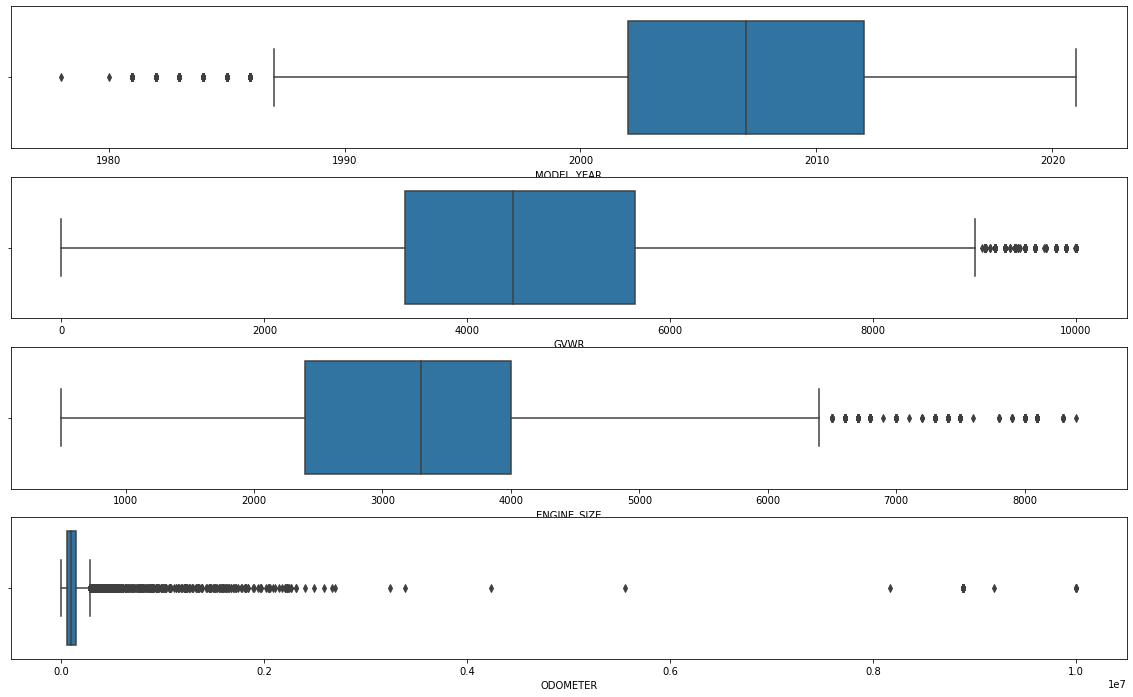

In [27]:
numeric_cols = ['MODEL_YEAR', 'GVWR', 'ENGINE_SIZE', 'ODOMETER']

fig, axs = plt.subplots(4, 1, figsize=(20, 12))
for col, ax in zip(numeric_cols, axs.flat):
    print(col, df[col].sort_values().values[0], df[col].sort_values().values[-1])
    sns.boxplot(x=df[col], ax=ax)

In [28]:
df.head()

,RESULT,TEST_TYPE,TEST_SDATE,TEST_EDATE,VIN,ZIP_CODE,VEHICLE_TYPE,MODEL_YEAR,MAKE,MODEL,GVWR,CYL,ENGINE_SIZE,TRANS_TYPE,ODOMETER,FUEL_TYPE
RecordID,,,,,,,,,,,,,,,,
2690332,1,A,2013-03-04 10:11:00,2013-03-04 10:14:00,1G4HP52K45U160372,87121,1,2005,BUICK,LESABRE,3875,6,3800,A,114034,G
2804644,1,I,2013-07-22 16:55:00,2013-07-22 16:56:00,3VWSF71K66M706988,87108,1,2006,VOLKSWAGEN,JETTA,3250,5,2500,M,76338,G
2779074,1,I,2013-06-18 12:45:00,2013-06-18 12:47:00,1FTRX17W43NA86035,87112,3,2003,FORD,F150 2WD,6050,8,4600,A,104849,G
2761810,1,I,2013-05-29 16:17:00,2013-05-29 16:18:00,JTEEP21A560170542,87119,4,2006,TOYOTA,HIGHLANDER 4WD,5360,6,3300,A,70130,G
2733004,0,I,2013-04-22 15:54:00,2013-04-22 15:58:00,1G1ZT52865F313274,87111,1,2005,CHEVROLET,MALIBU,3375,6,3500,A,133251,G


### strings

In [29]:
# select string columns

string_cols = ['VIN', 'ZIP_CODE', 'MODEL_YEAR', 'MAKE', 'MODEL']

# tranform string columns

def to_string(df, string_cols):
    for col in string_cols:
        df[col] = df[col].astype('string').str.strip().str.lower()
        df
    return df

df = to_string(df, string_cols)
print(df[string_cols].dtypes)
df[string_cols].head()

VIN           string
ZIP_CODE      string
MODEL_YEAR    string
MAKE          string
MODEL         string
dtype: object


,VIN,ZIP_CODE,MODEL_YEAR,MAKE,MODEL
RecordID,,,,,
2690332,1g4hp52k45u160372,87121,2005,buick,lesabre
2804644,3vwsf71k66m706988,87108,2006,volkswagen,jetta
2779074,1ftrx17w43na86035,87112,2003,ford,f150 2wd
2761810,jteep21a560170542,87119,2006,toyota,highlander 4wd
2733004,1g1zt52865f313274,87111,2005,chevrolet,malibu


In [30]:
df[string_cols].isnull().sum()

VIN           0
ZIP_CODE      0
MODEL_YEAR    0
MAKE          0
MODEL         2
dtype: int64

In [31]:
# using the historical values for that VIN fill in the missing MODEL values
vin = df[df.MODEL.isnull()].VIN.values[0]
model = df[df.VIN==vin].MODEL.values[-1]
df.loc[df.MODEL.isnull(), 'MODEL'] = model
df.MODEL.isnull().sum()

0

In [32]:
# make + model + year
df['MAKE_MODEL_YEAR'] = df.MAKE + '/' + df.MODEL + '/' + df.MODEL_YEAR
print("unique MAKE_MODEL_YEAR:", df.MAKE_MODEL_YEAR.nunique())

# drop MAKE and MODEL
df = df.drop(columns=['MAKE', 'MODEL'])

print("total records:", df.shape[0])

unique MAKE_MODEL_YEAR: 11684
total records: 187503


In [33]:
ABQ_zipcodes = [87101, 87102, 87103, 87104, 
                87105, 87106, 87107, 87108, 87109,
                87110, 87111, 87112, 87113, 87114,
                87115, 87116, 87119, 87120, 87121,
                87122, 87123, 87125, 87131, 87151,
                87153, 87154, 87158, 87176, 87181, 
                87184, 87185, 87187, 87190, 87191,
                87192, 87193, 87194, 87195, 87196, 
                87197, 87198, 87199]

# extract ZIP_CODE
def extract_zipcode(df, col):
    # whether from the city
    df['ABQ'] = 0
    df.loc[df[col].str[:3]=='871', 'ABQ'] = 1
    # which part of the city
    df['DISTRICT'] = df[col].str[3:].str.strip('-')
    return df

# drop ZIP_CODE
df = df.drop(columns=['ZIP_CODE'])

In [34]:
df.select_dtypes(include='string').head()

,VIN,MODEL_YEAR,MAKE_MODEL_YEAR
RecordID,,,
2690332,1g4hp52k45u160372,2005,buick/lesabre/2005
2804644,3vwsf71k66m706988,2006,volkswagen/jetta/2006
2779074,1ftrx17w43na86035,2003,ford/f150 2wd/2003
2761810,jteep21a560170542,2006,toyota/highlander 4wd/2006
2733004,1g1zt52865f313274,2005,chevrolet/malibu/2005


In [35]:
# vehicles from a specific brand/model/year fails the test?
tmp = df.groupby('MAKE_MODEL_YEAR')['RESULT'].value_counts().unstack(level=1)
tmp[(tmp[0] > 2) & tmp[1].isnull()]

RESULT,0,1
MAKE_MODEL_YEAR,,
bmw/335d/2011,3.0,NaN
buick/regal/1987,4.0,NaN
chevrolet/astro awd/1998,3.0,NaN
chevrolet/c1500/1989,4.0,NaN
ford/econoline cargo van/2001,3.0,NaN
freightliner/sprinter/2007,3.0,NaN
isuzu/trooper/1993,3.0,NaN
pontiac/passenger/2006,3.0,NaN
saturn/sl2/2002,3.0,NaN


### dates


In [36]:
# select date columns
date_cols = ['TEST_SDATE', 'TEST_EDATE']

# transform date columns
def to_datetime(df, date_cols):
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])
    return df

df = to_datetime(df, date_cols)
print(df[date_cols].dtypes)
df[date_cols].head()

TEST_SDATE    datetime64[ns]
TEST_EDATE    datetime64[ns]
dtype: object


,TEST_SDATE,TEST_EDATE
RecordID,,
2690332,2013-03-04 10:11:00,2013-03-04 10:14:00
2804644,2013-07-22 16:55:00,2013-07-22 16:56:00
2779074,2013-06-18 12:45:00,2013-06-18 12:47:00
2761810,2013-05-29 16:17:00,2013-05-29 16:18:00
2733004,2013-04-22 15:54:00,2013-04-22 15:58:00


**⚠️ if a vehicle has multiple records from the same date, keep earliest record**


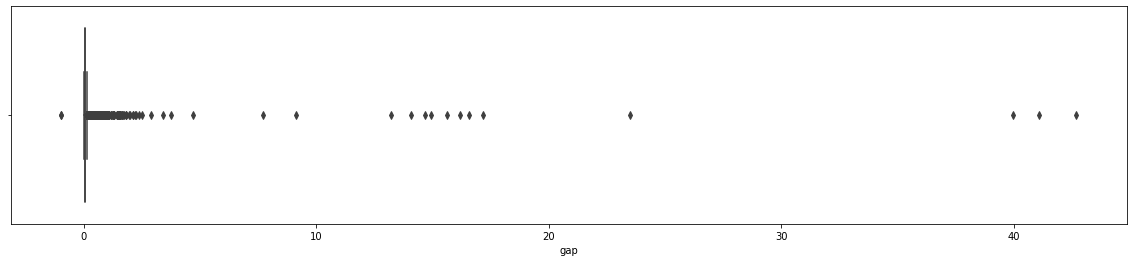

In [37]:
# the gap between test ending time and test starting time
df['gap'] = (df['TEST_EDATE'] - df['TEST_SDATE'])/timedelta(hours=1)
# distribution of gap
plt.figure(figsize=(20, 4))
sns.boxplot(x=df.gap);
# drop gap column
df = df.drop(columns=['gap'])

In [38]:
# add a helper column which has date but not hours of the day
df['TEST_DATE'] = df['TEST_SDATE'].dt.date

# keep the first record from the same date for each vehicle
df1 = df.loc[df.groupby(['VIN', 'TEST_DATE'])['TEST_SDATE'].idxmin(),:].copy()

# select the records whose vehicles got tested more than 1 time a day, can capture some extra information here
df2 = df[~df.index.isin(df1.index)]
print("records where vehicles got tested more than 1 time a day:", df2.shape[0])
print("records after removing repeated tests from same day:", df1.shape[0])

# date range
print('data range:', df1.TEST_DATE.min(), df1.TEST_DATE.max())

# drop the some columns
df = df1.drop(columns=['TEST_DATE', 'TEST_EDATE'])

records where vehicles got tested more than 1 time a day: 4046
records after removing repeated tests from same day: 183457
data range: 2013-01-01 2020-12-31


In [39]:
# check the distribution of target
df.RESULT.value_counts()

1    170120
0     13337
Name: RESULT, dtype: int64

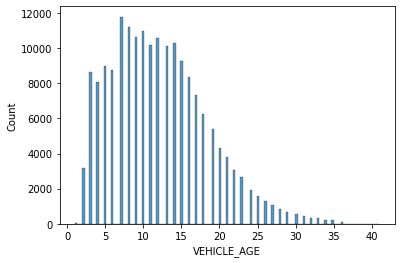

In [40]:
# engineering VEHICLE_AGE
df['VEHICLE_AGE'] = df.TEST_SDATE.dt.year.astype('int') - df.MODEL_YEAR.astype('int') + 2

# drop TEST_SDATE
# df = df.drop(columns=['TEST_SDATE'])

# check out the VEHICLE_AGE distribution
sns.histplot(data=df, x='VEHICLE_AGE');

Age distribution of vehicles which PASSED in emission test


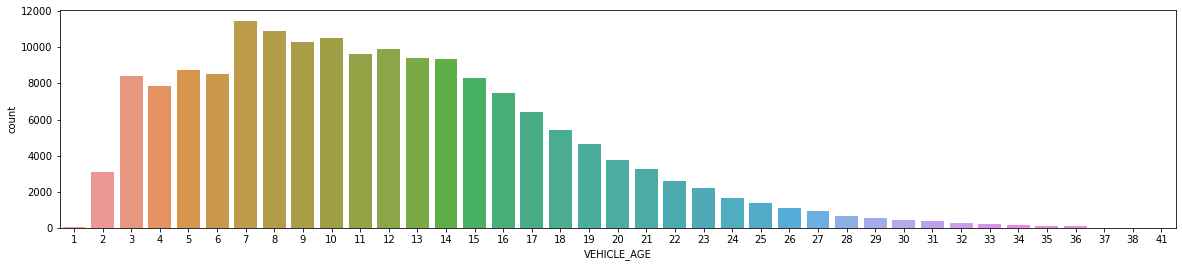

In [41]:
print("Age distribution of vehicles which PASSED in emission test")
plt.figure(figsize=(20,4))
sns.countplot(data=df[df.RESULT==1], x='VEHICLE_AGE');

Age distribution of vehicles which FAILED in emission test


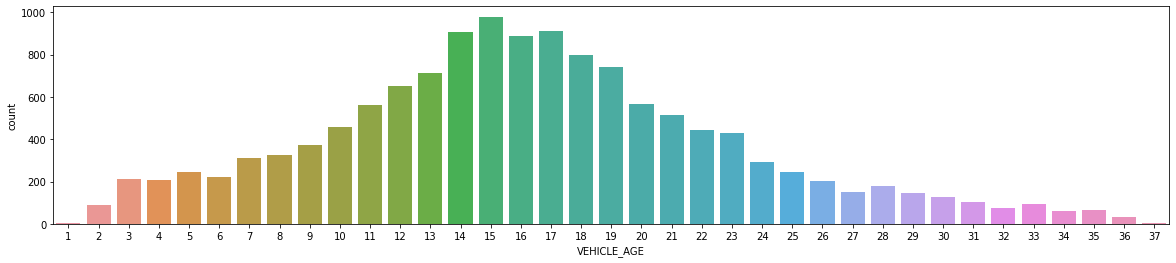

In [42]:
print("Age distribution of vehicles which FAILED in emission test")
plt.figure(figsize=(20,4))
sns.countplot(data=df[df.RESULT==0], x='VEHICLE_AGE');

In [43]:
def extract_time(df, col):
    df['month'] = df[col].dt.month
    df['weekday'] = df[col].dt.weekday
    df['hour'] = df[col].dt.hour
    return df

# df = extract_time(df, 'TEST_SDATE')

In [44]:
# sns.pairplot(data=df[['RESULT', 'month', 'weekday', 'hour']], corner=True)

### categorical columns 

In [45]:
categorical_cols = ['TEST_TYPE', 
                    'TRANS_TYPE', 
                    'VEHICLE_TYPE', 
                    'FUEL_TYPE', 
                    'CYL']

df[categorical_cols].isnull().sum()

TEST_TYPE       0
TRANS_TYPE      0
VEHICLE_TYPE    0
FUEL_TYPE       0
CYL             0
dtype: int64

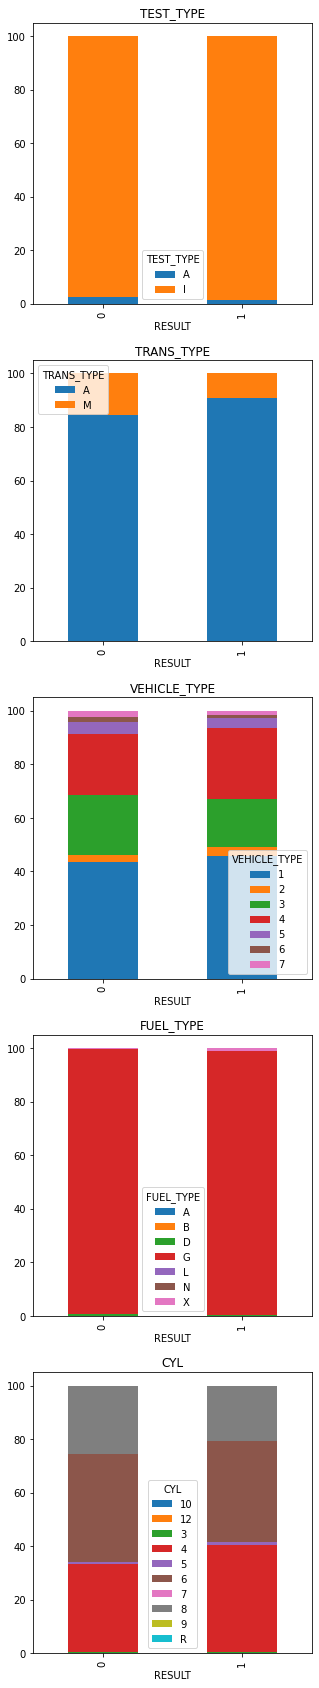

In [46]:
# distribution of categorical values in Pass and Fail data sets
df['count'] = 1
n = len(categorical_cols)
fig, axs = plt.subplots(n, 1, figsize=(5, 6*n))
for col, ax in zip(categorical_cols, axs.flat):
    tmp = df.groupby(['RESULT', col])['count'].count().groupby('RESULT').apply(lambda x: 100*x/x.sum()).unstack(level=1)
    tmp.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(col)
df = df.drop(columns=['count'])

In [47]:
# TEST_TYPE
df = df.replace({'TEST_TYPE':{'I':0, 'A':1}})
df.TEST_TYPE.value_counts()

0    180901
1      2556
Name: TEST_TYPE, dtype: int64

In [48]:
# TRANS_TYPE
df = df.replace({'TRANS_TYPE':{'A':0, 'M':1}})
df.TRANS_TYPE.value_counts()

0    165895
1     17562
Name: TRANS_TYPE, dtype: int64

MAKE_MODEL_YEARs with more than 1 VEHICLE_TYPE assigned to them: 956


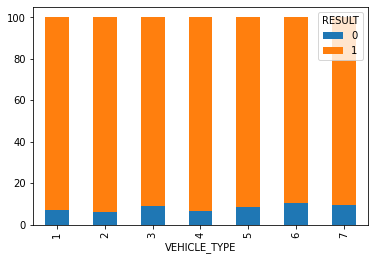

In [49]:
# VEHICLE_TYPE
# for each vehicle tpye, compare pass and fail
df.groupby(['VEHICLE_TYPE', 'RESULT']).size()\
    .groupby('VEHICLE_TYPE').apply(lambda x: 100*x/x.sum())\
    .unstack(level=1).plot(kind='bar', stacked=True);

# check how many records have more than 1 VEHICLE_TYPE were assigned to the same MAKE_MODEL_YEAR
tmp = df[['VEHICLE_TYPE', 'MAKE_MODEL_YEAR']].groupby('MAKE_MODEL_YEAR').nunique().sort_values('VEHICLE_TYPE')
print('MAKE_MODEL_YEARs with more than 1 VEHICLE_TYPE assigned to them:', tmp[tmp.VEHICLE_TYPE > 1].shape[0])

0    183375
1        82
Name: CYL_912R, dtype: int64


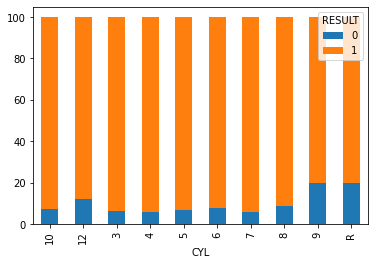

In [50]:
# CYL
# for each CYL, compare pass and fail
df.groupby(['CYL', 'RESULT']).size()\
    .groupby('CYL').apply(lambda x: 100*x/x.sum())\
    .unstack(level=1).plot(kind='bar', stacked=True);

df['CYL_912R'] = 0
df.loc[df.CYL.isin(['9', '12', 'R']), 'CYL_912R'] = 1
print(df.CYL_912R.value_counts())

In [51]:
# drop CYL
df = df.drop(columns=['CYL', 'CYL_912R'])

RESULT  FUEL_TYPE
1       L            4
Name: FUEL_TYPE, dtype: int64


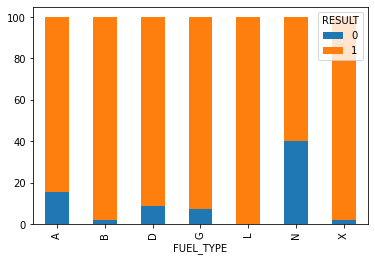

In [52]:
# FUEL TYPE 
# for each FUEL_TYPE, compare pass and fail
df.groupby(['FUEL_TYPE', 'RESULT']).size()\
    .groupby('FUEL_TYPE').apply(lambda x: 100*x/x.sum())\
    .unstack(level=1).plot(kind='bar', stacked=True);

# check FUEL_TYPE L
print(df[df.FUEL_TYPE=='L'].groupby('RESULT')['FUEL_TYPE'].value_counts())

# drop FUEL_TYPE
df = df.drop(columns=['FUEL_TYPE'])

In [53]:
df.head()

,RESULT,TEST_TYPE,TEST_SDATE,VIN,VEHICLE_TYPE,MODEL_YEAR,GVWR,ENGINE_SIZE,TRANS_TYPE,ODOMETER,MAKE_MODEL_YEAR,VEHICLE_AGE
RecordID,,,,,,,,,,,,
4118828,0,0,2018-04-11 13:54:28,0bbsk5468mz014126,1,1991,2625,1600,0,215161,geo/prizm/1991,29
3716231,1,0,2016-10-15 15:09:00,0s2rc61h045251900,1,2004,3000,2300,0,156888,suzuki/aerio/2004,14
2643540,1,0,2013-01-03 16:45:00,0t3hn86r919053130,4,2001,4250,3400,0,124227,toyota/4runner 4wd/2001,14
3870644,1,0,2017-05-13 14:56:00,107ha182x6j111384,3,2006,6000,5700,0,66315,dodge/ram 1500 2wd/2006,13
3951493,1,0,2017-08-24 17:59:00,124al2ap0an440796,1,2010,3375,2500,0,112471,nissan/altima/2010,9


### numeric columns



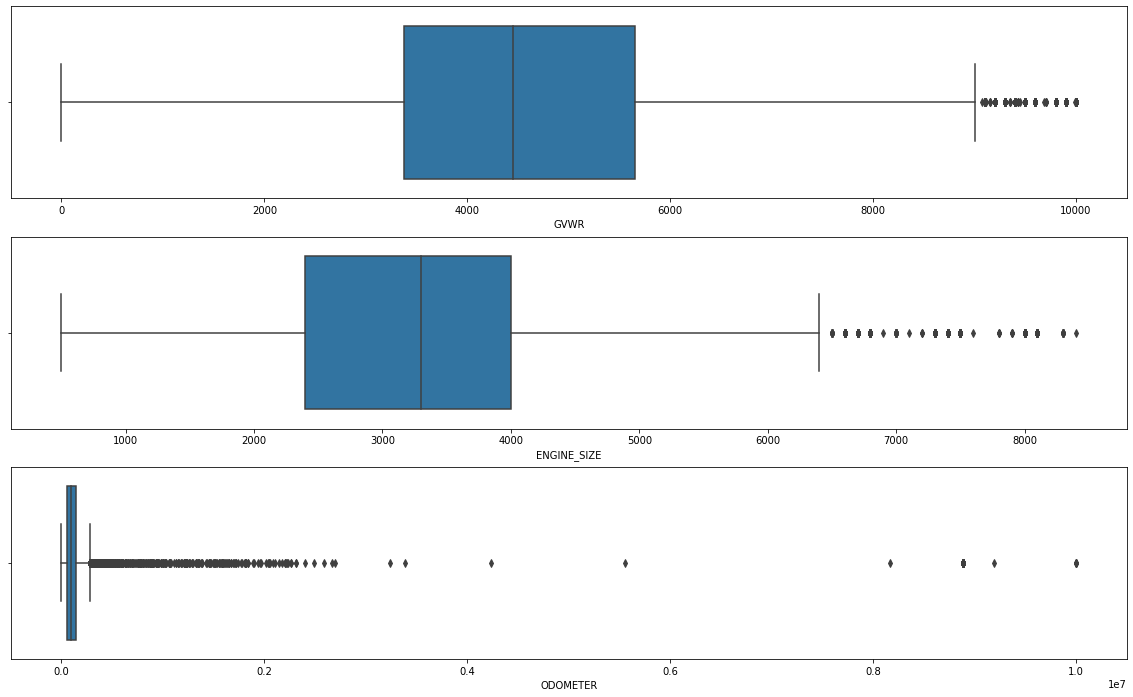

In [54]:
numeric_cols = ['GVWR', 'ENGINE_SIZE', 'ODOMETER']

fig, axs = plt.subplots(3, 1, figsize=(20, 12))
for col, ax in zip(numeric_cols, axs.flat):
    sns.boxplot(x=df[col], ax=ax)

In [55]:
# statistics
df[numeric_cols].describe()

,GVWR,ENGINE_SIZE,ODOMETER
count,183457.000000,183457.000000,1.834570e+05
mean,4486.768829,3339.867310,1.094969e+05
std,1847.992704,1288.911162,2.184283e+05
min,0.000000,500.000000,0.000000e+00
25%,3381.000000,2400.000000,5.326300e+04
50%,4450.000000,3300.000000,9.665100e+04
75%,5650.000000,4000.000000,1.441350e+05
max,10000.000000,8400.000000,9.999999e+06


GVWR_0 = 0: 11577
GVWR = 0: 9180
GVWR_0 > 9000: 2311
GVWR > 9000: 2275


1    7560
0     382
Name: RESULT, dtype: int64

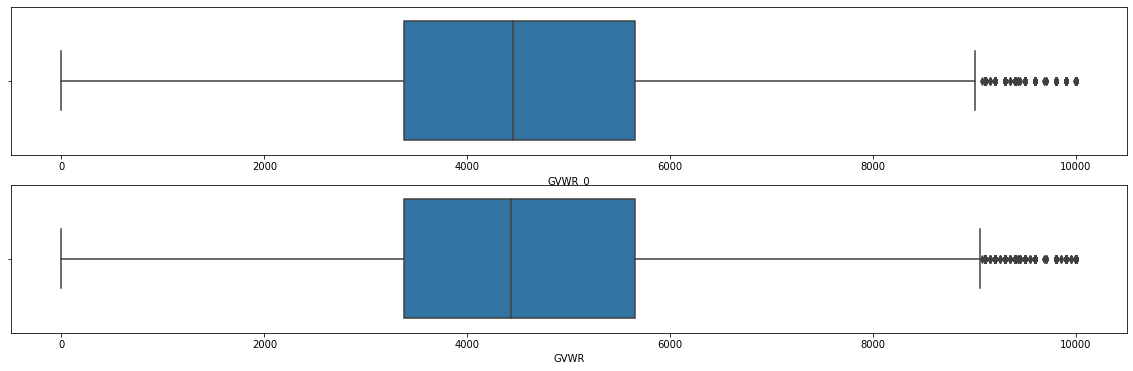

In [56]:
# let's clean GVWR a little bit

# get median GVWR of each VIN
tmp = df[['VIN', 'GVWR']].groupby('VIN').agg({'GVWR':'median'})
tmp.reset_index(inplace=True)

# merge tmp with df
df.reset_index(inplace=True)
df = df.merge(tmp, how='left', on='VIN', suffixes=('_0',''))
df.set_index('RecordID', inplace=True)

# missing values in GVWR and GVWR_0
print('GVWR_0 = 0:', df[df.GVWR_0==0].shape[0])
print('GVWR = 0:', df[df.GVWR==0].shape[0])

# outliers in GVWR and GVWR_0
print('GVWR_0 > 9000:', df[df.GVWR_0 > 9000].shape[0])
print('GVWR > 9000:', df[df.GVWR > 9000].shape[0])

# distribution of GVWR and GVWR_0
cols = ['GVWR_0', 'GVWR']

fig, axs = plt.subplots(2, 1, figsize=(20, 6))
for col, ax in zip(cols, axs.flat):
    sns.boxplot(x=df[col], ax=ax)

# replace 0 with np.nan
df.loc[df.GVWR==0, 'GVWR'] = np.nan
df.loc[df.GVWR_0==0, 'GVWR_0'] = np.nan

# using GVWR_0 fill missing values in GVWR
df['GVWR'] = df.GVWR.fillna(df.GVWR_0)

# keep GVW and drop GVWR_0
df = df.drop(columns=['GVWR_0'])

# check share of P and F in missing values
df.loc[df.GVWR.isnull(), 'RESULT'].value_counts()

In [57]:
# 0 in ODOMETER
df.loc[df.ODOMETER==0, 'ODOMETER'] = np.nan
print('number of ODOMETER=0:', df.ODOMETER.isnull().sum())
df.loc[df.ODOMETER.isnull(), 'RESULT'].value_counts()

number of ODOMETER=0: 875


1    746
0    129
Name: RESULT, dtype: int64

records where MILE_YEAR > 100,000 miles: 202
vehicles with ODOMETER > 100,000 miles: 192


<AxesSubplot:xlabel='MILE_YEAR'>

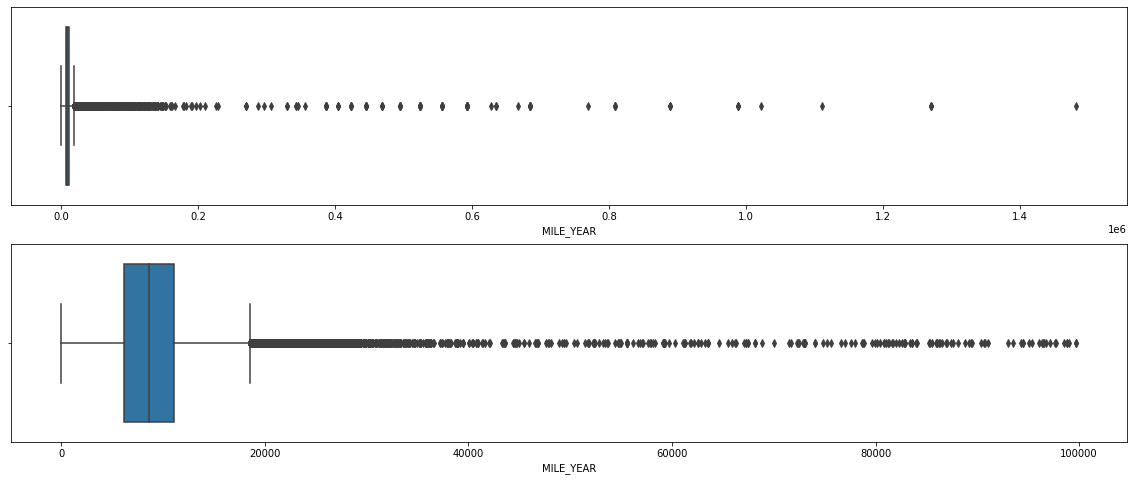

In [58]:
# drop ODOMETER = 0
df = df[df.ODOMETER!=0]

# engineer MILE_YEAR from ODOMETER
df['MILE_YEAR'] = df['ODOMETER']/df['VEHICLE_AGE']

# Americans drive an average of 14,300 miles per year
# outliers in MILE_YEAR
print('records where MILE_YEAR > 100,000 miles:', df[df.MILE_YEAR > 100000].shape[0])
print('vehicles with ODOMETER > 100,000 miles:', df[df.MILE_YEAR > 100000].VIN.nunique())

fig, axs = plt.subplots(2, 1, figsize=(20, 8))
sns.boxplot(x=df['MILE_YEAR'], ax=axs[0])
sns.boxplot(x=df[df.MILE_YEAR < 100000]['MILE_YEAR'], ax=axs[1])

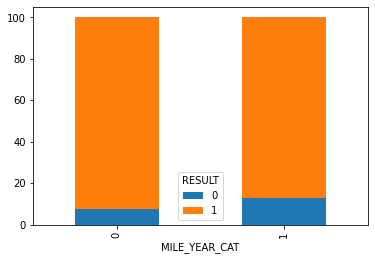

In [59]:
df['MILE_YEAR_CAT'] = df.MILE_YEAR.apply(lambda x: 1 if x > 40000 else 0)
df.groupby(['MILE_YEAR_CAT', 'RESULT']).size()\
    .groupby('MILE_YEAR_CAT').apply(lambda x: 100*x/x.sum())\
    .unstack(level=1).plot(kind='bar', stacked=True);
df = df.drop(columns=['MILE_YEAR_CAT'])

In [60]:
# drop useless columns
tmp = df.drop(columns=['TEST_SDATE', 'VIN', 'MODEL_YEAR'])

# drop na
tmp = tmp.dropna()

# data size
print(tmp.shape)

tmp.head()

(174651, 10)


,RESULT,TEST_TYPE,VEHICLE_TYPE,ENGINE_SIZE,TRANS_TYPE,ODOMETER,MAKE_MODEL_YEAR,VEHICLE_AGE,GVWR,MILE_YEAR
RecordID,,,,,,,,,,
4118828,0,0,1,1600,0,215161.0,geo/prizm/1991,29,2625.0,7419.344828
3716231,1,0,1,2300,0,156888.0,suzuki/aerio/2004,14,3000.0,11206.285714
2643540,1,0,4,3400,0,124227.0,toyota/4runner 4wd/2001,14,4250.0,8873.357143
3870644,1,0,3,5700,0,66315.0,dodge/ram 1500 2wd/2006,13,6000.0,5101.153846
3951493,1,0,1,2500,0,112471.0,nissan/altima/2010,9,3375.0,12496.777778


## vehicles with historical records


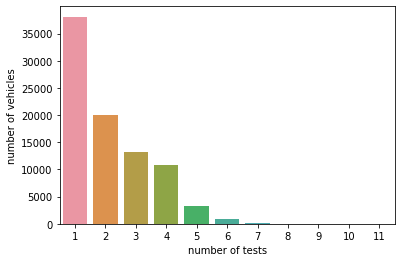

In [61]:
# how many vehicle were tested how many times
tmp = df.VIN.value_counts().sort_values()
ax = sns.countplot(x=tmp)
ax.set(ylabel='number of vehicles', xlabel='number of tests');

In [62]:
df.VIN.value_counts().value_counts()

1     38089
2     20087
3     13154
4     10760
5      3182
6       797
7       205
8        47
9        13
10        5
11        2
Name: VIN, dtype: int64

In [63]:
# let's check a vehicle that was tested 10 times
df[df.VIN == df.VIN.value_counts().sort_values(ascending=False).index[5]]

,RESULT,TEST_TYPE,TEST_SDATE,VIN,VEHICLE_TYPE,MODEL_YEAR,ENGINE_SIZE,TRANS_TYPE,ODOMETER,MAKE_MODEL_YEAR,VEHICLE_AGE,GVWR,MILE_YEAR
RecordID,,,,,,,,,,,,,
2659334,0,0,2013-01-24 16:34:00,4tarn01p3rz215462,3,1994,2200,1,172578.0,toyota/pickup/1994,21,5400.0,8218.000000
2663029,0,1,2013-01-30 17:03:00,4tarn01p3rz215462,3,1994,2200,1,172662.0,toyota/pickup/1994,21,5400.0,8222.000000
2666215,1,0,2013-02-01 11:42:00,4tarn01p3rz215462,3,1994,2200,1,72679.0,toyota/pickup/1994,21,5400.0,3460.904762
3189727,0,0,2015-01-05 13:45:00,4tarn01p3rz215462,3,1994,2400,1,177371.0,toyota/pickup/1994,23,5400.0,7711.782609
3210402,0,0,2015-02-02 11:42:00,4tarn01p3rz215462,3,1994,2200,1,177876.0,toyota/pickup/1994,23,5400.0,7733.739130
3212071,1,1,2015-02-03 16:03:00,4tarn01p3rz215462,3,1994,2200,1,177879.0,toyota/pickup/1994,23,5400.0,7733.869565
3497262,1,0,2016-01-12 16:15:00,4tarn01p3rz215462,3,1994,2200,1,180892.0,toyota/pickup/1994,24,5400.0,7537.166667
3773678,1,0,2017-01-11 15:23:29,4tarn01p3rz215462,3,1994,2200,1,182426.0,toyota/pickup/1994,25,5400.0,7297.040000
4056734,1,0,2018-01-26 15:41:45,4tarn01p3rz215462,3,1994,2200,1,183254.0,toyota/pickup/1994,26,5400.0,7048.230769


### current records + last test records


In [64]:
# all the records where vehicles didn't receive test before
df1 = df.loc[df.groupby('VIN')['TEST_SDATE'].idxmin(),:]

# records whose vehicle has historical data
tmp = df.VIN.value_counts()
df2 = df[df.VIN.isin(tmp[tmp>1].index)]

print("Records where vehicles didn't receive test before", df1.shape)
print("Records where vehicles have historical data", df2.shape)

Records where vehicles didn't receive test before (86341, 13)
Records where vehicles have historical data (145368, 13)


In [65]:
# merge historical data once on VIN
df3 = df2.reset_index()
df4 = df2.drop(columns=['MODEL_YEAR', 'MAKE_MODEL_YEAR']).reset_index()
merge = pd.merge(df3, df4, how='left', on='VIN', suffixes=(None, '_1'))


# add a helper column
merge['DELTA'] = merge['TEST_SDATE']-merge['TEST_SDATE_1']

# keep the entries where TEST_DATE_1 is earlier than TEST_DATE
merge = merge[merge.DELTA > timedelta(days=0)]
merge.reset_index(drop=True, inplace=True)


# keep the rows whose DELTA is > 90, meaning vehicle's last check up was at least 90 days earlier than this time

# print(merge.shape)
# merge = merge[merge.DELTA > timedelta(days=90)]
# merge.reset_index(inplace=True)
# print(merge.shape)

# for each RecordID only keep most recent record as previous testing record
df_hist = merge.loc[merge.groupby('RecordID')['DELTA'].idxmin(), :]
df_hist.set_index('RecordID', inplace=True)

print("records in historical dataframe", df_hist.shape[0])
print("unique records in historical dataframe", df_hist.index.nunique())

print("\nStatistic summary of time gaps between current and last tests\n")
df_hist.DELTA.describe()

records in historical dataframe 97116
unique records in historical dataframe 97116

Statistic summary of time gaps between current and last tests



count                          97116
mean     632 days 18:38:11.296501080
std      357 days 17:42:52.076980080
min                  0 days 09:46:41
25%         389 days 21:08:47.750000
50%                724 days 03:05:04
75%                757 days 22:13:00
max               2821 days 01:08:10
Name: DELTA, dtype: object

In [66]:
# stack df1 and df_hist
updated_df = pd.concat([df1, df_hist])
print("Shape of the new dataframe", updated_df.shape)

updated_df.sort_index().tail()

Shape of the new dataframe (183457, 25)


,RESULT,TEST_TYPE,TEST_SDATE,VIN,VEHICLE_TYPE,MODEL_YEAR,ENGINE_SIZE,TRANS_TYPE,ODOMETER,MAKE_MODEL_YEAR,VEHICLE_AGE,GVWR,MILE_YEAR,RecordID_1,RESULT_1,TEST_TYPE_1,TEST_SDATE_1,VEHICLE_TYPE_1,ENGINE_SIZE_1,TRANS_TYPE_1,ODOMETER_1,VEHICLE_AGE_1,GVWR_1,MILE_YEAR_1,DELTA
RecordID,,,,,,,,,,,,,,,,,,,,,,,,,
4843554,1,0,2020-12-31 16:34:16,1g3nl52f74c169657,1,2004,2200,0,120430.0,oldsmobile/alero/2004,18,3250.0,6690.555556,3994340.0,1.0,0.0,2017-10-25 11:09:37,1.0,2200.0,0.0,84307.0,15.0,3250.0,5620.466667,1163 days 05:24:39
4843592,1,0,2020-12-31 17:39:11,kmhdu46d88u315460,1,2008,2000,1,153137.0,hyundai/elantra/2008,14,3125.0,10938.357143,4638360.0,1.0,0.0,2020-03-07 12:53:20,1.0,2000.0,1.0,144535.0,14.0,3125.0,10323.928571,299 days 04:45:51
4843654,1,0,2020-12-31 12:36:33,salgs5rexja381770,4,2018,5000,0,13703.0,land rover/range rover sport/2018,4,6700.0,3425.750000,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4844491,1,0,2020-12-29 14:19:52,3gnek13t22g185380,3,2002,5300,0,NaN,chevrolet/avalanche 4wd/2002,20,7000.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4844706,1,0,2020-12-31 16:13:15,1hgcg56612a017292,1,2002,2300,0,139330.0,honda/accord/2002,20,3665.0,6966.500000,4049454.0,1.0,0.0,2018-01-17 12:29:55,1.0,2300.0,0.0,124072.0,18.0,3665.0,6892.888889,1079 days 03:43:20


### one entry for one vehicle


In [68]:
# keep most recent record for each vehicle

df1 = df.loc[df.groupby('VIN')['TEST_SDATE'].idxmax(),:]

# let's take the historical data out

df2 = df[~df.index.isin(df1.index)]

print("number records that don't belong to historical records:", df1.shape[0])
print('number of unique vehicles in df1:', df1.VIN.nunique())    
print('number records that belong to historical records:', df2.shape[0])

number records that don't belong to historical records: 86341
number of unique vehicles in df1: 86341
number records that belong to historical records: 97116


In [71]:
# let's peel the historical df2 like an onion into multiple dataframes according to timeline

older_records = [] # a list to collect dataframes

updated_df2 = df2

for i in range(10):
    print(f'getting layer {i}')
    latest = updated_df2.loc[updated_df2.groupby('VIN')['TEST_SDATE'].idxmax(), :]
    older_records.append(latest.reset_index())
    tmp = updated_df2[~updated_df2.index.isin(latest.index)]
    updated_df2 = tmp.copy()

getting layer 0
getting layer 1
getting layer 2
getting layer 3
getting layer 4
getting layer 5
getting layer 6
getting layer 7
getting layer 8
getting layer 9


In [72]:
# merge the dataframes in older_records with df1

updated_df2 = df1
for index, record in enumerate(older_records):
    merged_df = pd.merge(updated_df2, record, how='left', on='VIN', suffixes=(None, '_'+str(index+1)))
    updated_df2 = merged_df.copy()  

print('The size of one-entry-one-vehicle dataframe:', updated_df2.shape)

# let's check out the vehicles that were tested for 11 times in last 7 years
updated_df2[~updated_df2.RecordID_10.isnull()]

The size of one-entry-one-vehicle dataframe: (86341, 143)


,RESULT,TEST_TYPE,TEST_SDATE,VIN,VEHICLE_TYPE,MODEL_YEAR,ENGINE_SIZE,TRANS_TYPE,ODOMETER,MAKE_MODEL_YEAR,VEHICLE_AGE,GVWR,MILE_YEAR,RecordID,RESULT_1,TEST_TYPE_1,TEST_SDATE_1,VEHICLE_TYPE_1,MODEL_YEAR_1,ENGINE_SIZE_1,TRANS_TYPE_1,ODOMETER_1,MAKE_MODEL_YEAR_1,VEHICLE_AGE_1,GVWR_1,MILE_YEAR_1,RecordID_2,RESULT_2,TEST_TYPE_2,TEST_SDATE_2,VEHICLE_TYPE_2,MODEL_YEAR_2,ENGINE_SIZE_2,TRANS_TYPE_2,ODOMETER_2,MAKE_MODEL_YEAR_2,VEHICLE_AGE_2,GVWR_2,MILE_YEAR_2,RecordID_3,RESULT_3,TEST_TYPE_3,TEST_SDATE_3,VEHICLE_TYPE_3,MODEL_YEAR_3,ENGINE_SIZE_3,TRANS_TYPE_3,ODOMETER_3,MAKE_MODEL_YEAR_3,VEHICLE_AGE_3,GVWR_3,MILE_YEAR_3,RecordID_4,RESULT_4,TEST_TYPE_4,TEST_SDATE_4,VEHICLE_TYPE_4,MODEL_YEAR_4,ENGINE_SIZE_4,TRANS_TYPE_4,ODOMETER_4,MAKE_MODEL_YEAR_4,VEHICLE_AGE_4,GVWR_4,MILE_YEAR_4,RecordID_5,RESULT_5,TEST_TYPE_5,TEST_SDATE_5,VEHICLE_TYPE_5,MODEL_YEAR_5,ENGINE_SIZE_5,TRANS_TYPE_5,ODOMETER_5,MAKE_MODEL_YEAR_5,VEHICLE_AGE_5,GVWR_5,MILE_YEAR_5,RecordID_6,RESULT_6,TEST_TYPE_6,TEST_SDATE_6,VEHICLE_TYPE_6,MODEL_YEAR_6,ENGINE_SIZE_6,TRANS_TYPE_6,ODOMETER_6,MAKE_MODEL_YEAR_6,VEHICLE_AGE_6,GVWR_6,MILE_YEAR_6,RecordID_7,RESULT_7,TEST_TYPE_7,TEST_SDATE_7,VEHICLE_TYPE_7,MODEL_YEAR_7,ENGINE_SIZE_7,TRANS_TYPE_7,ODOMETER_7,MAKE_MODEL_YEAR_7,VEHICLE_AGE_7,GVWR_7,MILE_YEAR_7,RecordID_8,RESULT_8,TEST_TYPE_8,TEST_SDATE_8,VEHICLE_TYPE_8,MODEL_YEAR_8,ENGINE_SIZE_8,TRANS_TYPE_8,ODOMETER_8,MAKE_MODEL_YEAR_8,VEHICLE_AGE_8,GVWR_8,MILE_YEAR_8,RecordID_9,RESULT_9,TEST_TYPE_9,TEST_SDATE_9,VEHICLE_TYPE_9,MODEL_YEAR_9,ENGINE_SIZE_9,TRANS_TYPE_9,ODOMETER_9,MAKE_MODEL_YEAR_9,VEHICLE_AGE_9,GVWR_9,MILE_YEAR_9,RecordID_10,RESULT_10,TEST_TYPE_10,TEST_SDATE_10,VEHICLE_TYPE_10,MODEL_YEAR_10,ENGINE_SIZE_10,TRANS_TYPE_10,ODOMETER_10,MAKE_MODEL_YEAR_10,VEHICLE_AGE_10,GVWR_10,MILE_YEAR_10
69953,1,0,2020-06-15 15:42:56,jm1na3535r0503494,1,1994,1800,1,147254.0,mazda/miata/1994,28,2625.0,5259.071429,4615145.0,1.0,0.0,2020-02-08 09:57:01,1.0,1994,1800.0,1.0,144900.0,mazda/miata/1994,28.0,2625.0,5175.000,4309672.0,1.0,0.0,2018-12-29 11:13:44,1.0,1994,1800.0,1.0,137314.0,mazda/miata/1994,26.0,2625.0,5281.307692,3732894.0,1.0,0.0,2016-11-08 11:31:00,1.0,1994,1800.0,1.0,128221.0,mazda/miata/1994,24.0,2625.0,5342.541667,3611495.0,1.0,0.0,2016-06-03 16:41:00,1.0,1994,1800.0,1.0,127063.0,mazda/miata/1994,24.0,2625.0,5294.291667,3605790.0,0.0,1.0,2016-05-30 14:41:00,1.0,1994,1800.0,1.0,126950.0,mazda/miata/1994,24.0,2625.0,5289.583333,3573675.0,0.0,0.0,2016-04-18 15:39:00,1.0,1994,1800.0,1.0,126781.0,mazda/miata/1994,24.0,2625.0,5282.541667,3334094.0,1.0,1.0,2015-05-31 16:49:00,1.0,1994,1800.0,1.0,125431.0,mazda/miata/1994,23.0,2625.0,5453.521739,3332944.0,0.0,0.0,2015-05-29 15:19:00,1.0,1994,1800.0,1.0,125408.0,mazda/miata/1994,23.0,2625.0,5452.521739,2784833.0,1.0,1.0,2013-06-26 18:14:00,1.0,1994,1800.0,1.0,122541.0,mazda/miata/1994,21.0,2625.0,5835.285714,2779499.0,0.0,0.0,2013-06-19 16:38:00,1.0,1994,1800.0,1.0,122495.0,mazda/miata/1994,21.0,2625.0,5833.095238
78108,1,0,2020-11-06 14:08:40,km8jn12d86u437446,4,2006,2700,0,182874.0,hyundai/tucson/2006,16,4652.0,11429.625000,4810353.0,0.0,1.0,2020-11-03 13:10:10,4.0,2006,2700.0,0.0,182778.0,hyundai/tucson/2006,16.0,4652.0,11423.625,4809165.0,0.0,0.0,2020-11-02 11:22:58,4.0,2006,2700.0,0.0,182445.0,hyundai/tucson/2006,16.0,4652.0,11402.812500,4311860.0,1.0,0.0,2019-01-03 11:07:46,4.0,2006,2700.0,0.0,180605.0,hyundai/tucson/2006,15.0,4652.0,12040.333333,4285646.0,1.0,0.0,2018-11-21 13:25:29,4.0,2006,2700.0,0.0,179779.0,hyundai/tuscon/2006,14.0,4652.0,12841.357143,4044883.0,1.0,1.0,2018-01-11 10:00:56,4.0,2006,2700.0,0.0,169761.0,hyundai/tuscon/2006,14.0,4652.0,12125.785714,4036297.0,0.0,0.0,2017-12-30 14:06:00,4.0,2006,2700.0,0.0,169259.0,hyundai/tuscon/2006,13.0,4652.0,13019.923077,3753080.0,1.0,0.0,2016-12-09 13:24:00,4.0,2006,2600.0,0.0,152904.0,hyundai/tuscon/2006,12.0,4652.0,12742.000000,3577469.0,1.0,0.0,2016-04-23 12:25:00,4.0,2006,3500.0,0.0,144679.0,hyundai/tucson/2006,12.0,4652.0,12056.583333,3206872.0,1.0,0.0,2015-01-28 14:37:00,4.0,2